In [144]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [145]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [146]:
NUM_CLASSES = 3

# 学習データ読み込み

In [147]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [148]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [150]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [151]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                860       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [152]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [153]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [154]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.2291 - accuracy: 0.3438
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
2/2 [==============================] - 1s 367ms/step - loss: 1.2086 - accuracy: 0.3851 - val_loss: 1.1703 - val_accuracy: 0.2542
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.1901 - accuracy: 0.3828
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
2/2 [==============================] - 0s 96ms/step - loss: 1.1770 - accuracy: 0.3793 - val_loss: 1.1390 - val_accuracy: 0.2881
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.1594 - accuracy: 0.3516
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
2/2 [==============================] - 0s 98ms/step - loss: 1.1506 - accuracy: 0.3966 - val_loss: 1.1129 - val_accuracy: 0.3051
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.1347 - accuracy: 0.3438
Epoch 4: sa

In [155]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 33ms/step - loss: 0.0990 - accuracy: 0.9661


In [156]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [157]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.00163706 0.9886468  0.00971613]
1


# 混同行列

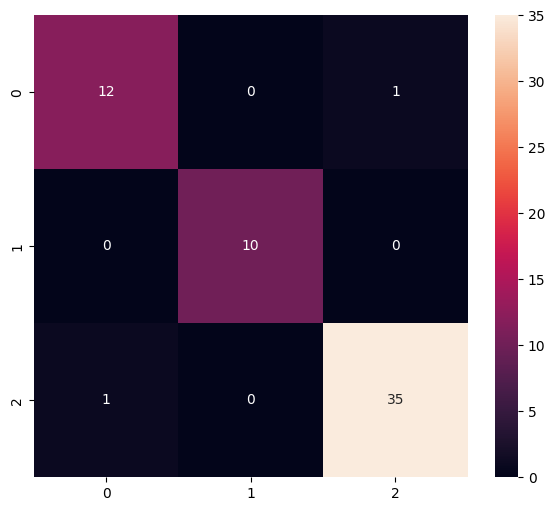

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       1.00      1.00      1.00        10
           2       0.97      0.97      0.97        36

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59



In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [159]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [160]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\tarun\AppData\Local\Temp\tmpukid7npg\assets


INFO:tensorflow:Assets written to: C:\Users\tarun\AppData\Local\Temp\tmpukid7npg\assets


6284

# 推論テスト

In [161]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [162]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [163]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [164]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [165]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00163706 0.9886468  0.00971613]
1
